# Analyze Dataset

In [23]:
from obspy import * 
from pandas import *
from os import listdir,uname

import netCDF4 as nc
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Configurations

In [24]:
config = {}

config['hostname'] = uname()[1]

if config['hostname'] == 'kilauea':
    config['workdir'] = "/export/data/LNM/data/"
    config['outdir_figures'] = "/home/brotzer/Documents/ROMY/LowNoiseModel/figures/"    
elif config['hostname'] == 'lighthouse':
    config['workdir'] = "/home/andbro/kilauea-data/LNM/data/"
    config['outdir_figures'] = "/home/andbro/Documents/ROMY/LowNoiseModel/figures/"
else: 
    print(f"Hostname: {config['hostname']} not known!")


config['love_phase_nc'] = "PHASE_VELOCITY_MODEL/LovePhaseVelocity.nc"
config['rayleigh_phase_nc'] = "PHASE_VELOCITY_MODEL/RayleighPhaseVelocity.nc"

config['datadir_spectra'] = config['workdir']+"2018/"

config['datadir_stats'] = config['workdir']+"STATS/"

config['spectra_files'] = listdir(config['datadir_spectra'])

config['noise_models'] =  config['workdir']+"MODELS/""noise_models.npz"

config['excluded_stations'] = ['KAPI', 'TRQA', 'QSPA', 'FUNA', 'SAML']

## Analyse Dataset 

In [25]:
stations = DataFrame()

stations['sta'] = config['spectra_files']

stations['names'] = [s.split("_")[1] for s in stations['sta']]

print(f"total stations:  {stations.names.size}")
print(f"unique stations: {stations.names.unique().size}")
select = [sta for sta in stations.names.unique() if sta not in config['excluded_stations']]
print(f"unique stations (excluded): {len(select)}")

stations['count'] = np.ones(stations.names.size)


new = stations.groupby(by='names')['count'].sum()

total stations:  272
unique stations: 144
unique stations (excluded): 139


<Figure size 1080x360 with 0 Axes>

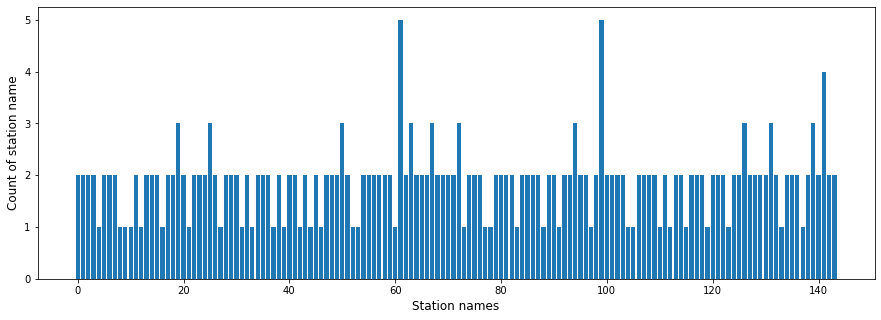

In [26]:
plt.figure(figsize=(15,5))

plt.figure(figsize=(15,5))
plt.bar(range(new.index.size), height=new)

plt.ylabel("Count of station name", fontsize=12)
plt.xlabel("Station names", fontsize=12)

plt.show();

## Show multiple Channel Stations

In [27]:
stations['count'] = np.ones(stations.names.size)

test = stations[stations.names.duplicated()]
names = test.names.unique()

counts = test.groupby(by=["names"])['count'].sum()

df = DataFrame()
df['counts'] = counts+1
df['names'] = names

df = df[df.counts > 2]

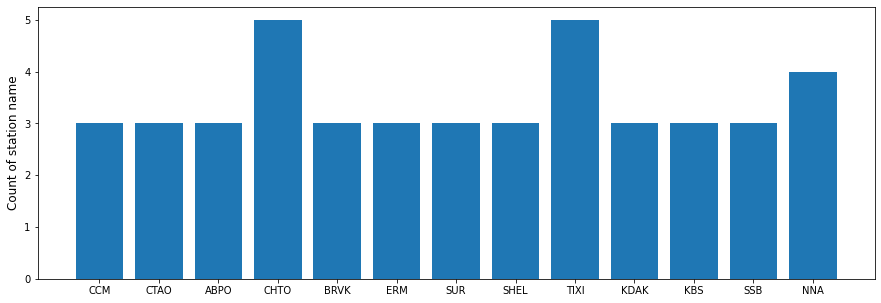

In [28]:
plt.figure(figsize=(15,5))

plt.bar(df['names'], df['counts'])

plt.ylabel("Count of station name", fontsize=12)

plt.show();

## Check Spectra of Stations

In [29]:
medians_2018 = read_pickle(config['datadir_stats']+"2018_medians.pkl")

pp = 1/medians_2018['frequencies']

Plot all median spectra of stations to identified corrupted ones

In [ ]:
import time

tmp = np.load(config['noise_models'])
nm_periods, nlnm, nhnm = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp


for sta in medians_2018.keys():
    print(sta)

    if sta != "frequencies":
        plt.figure(figsize=(15,5))
        plt.semilogx(1/medians_2018['frequencies'], medians_2018[sta], label=sta)
        plt.semilogx(nm_periods, nlnm, label="NLNM")
        plt.xlim(2.5,300)
        plt.xlabel("Period (s)")
        plt.legend(loc="upper right")
        plt.ylabel(r"PSD (dB rel. to 1 $m^2/s^4$ / Hz)")
        plt.show();
        time.sleep(1)

Plot selection of spectra (exclulding corrupt ones)

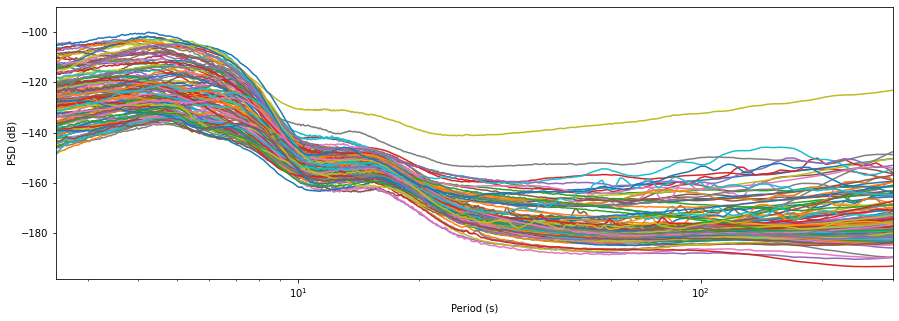

In [30]:
df = medians_2018.copy()

plt.figure(figsize=(15,5))

for sta in df.keys():
    if sta == "frequencies":
        continue
        
    if sta.split(".")[0] in config['excluded_stations']:
        continue
        
    plt.plot(1/df.frequencies, df[sta])

    
plt.xlim(2.5, 300)
plt.xlabel("Period (s)")
plt.ylabel("PSD (dB)")

plt.xscale("log")
plt.show();

### Plot as PPSD

In [31]:
def __conversion(data, informat=None, outformat=None):
    '''
    data:                  array 
    informat/outformat:    ASD, PSD, DB
    '''
    from numpy import log10, sqrt
    
    
    if informat == 'ASD' and outformat == 'PSD':
        return data**2
    
    elif informat == 'PSD' and outformat == 'ASD':
        return sqrt(data)

    elif informat == 'ASD' and outformat == 'DB':
        return 10*log10(data)
    
    elif informat == 'PSD' and outformat == 'DB':
        return 10*log10(data)
    
    elif informat == 'DB' and outformat == 'PSD':
        return 10**(data/10)
    
    elif informat == 'DB' and outformat == 'ASD':
        return sqrt(10**(data/10))
    
    else:
        print(" -> specified case not defined!")

In [32]:
array = np.array([medians_2018[sta] for sta in medians_2018.keys() if sta is not 'frequencies' and sta.split(".")[0] not in config['excluded_stations']])

psds = __conversion(array, informat='DB', outformat='PSD')

In [33]:
def __calculate_density(psd_array, bins=20, density=False):

    from numpy import argmax, std, median, isnan, array, histogram

    
    def __convert_to_log(in_psds):

        print(in_psds.shape)

        out_psds = np.zeros(in_psds.shape)
        rows_with_zeros = 0
        for i, psd in enumerate(in_psds):
            if np.count_nonzero(psd) != len(psd):
                rows_with_zeros +=1
                psd = [nan for val in psd if val == 0]
            out_psds[i,:] = np.log10(psd)
            if np.isinf(out_psds[i,:]).any():
                out_psds[i,:] = nan * ones(len(out_psds[i,:]))

        return out_psds

    psd_array = __convert_to_log(psd_array)
    
    psds = []
    for psd in psd_array:
        if not isnan(psd).all():
            psds.append(psd)
    psd_array = array(psds)
    
    max_value = max([max(sublist) for sublist in psd_array])
    min_value = min([min(sublist) for sublist in psd_array])


    dist, dist_maximas, bins_maximas, bins_medians, stds = [], [], [], [], []

    for h in range(len(psd_array[1])):
        
        psd = psd_array[:,h]
        
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);
        
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
#         if density:
#             hist = [val / len(psd_array[:,h]) for val in hist]
        
        
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        
        psd = psd[~(isnan(psd))]
        bins_medians.append(median(psd[psd != 0]))

    ## undo log conversion    
    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = 10**array(bin_mids)
    output['bins_maximas'] = 10**array(bins_maximas)
    output['stds'] = 10**array(stds)
    output['bins_medians'] = 10**array(bins_medians)
    output['set_density'] = density
    output['total'] = psd_array.shape[0]
    
    return output

In [61]:
def __makeplot_PPSD(ff, output, config, mode="DB", plot_noise_models=False):

    from matplotlib import colors
    from numpy import ones, convolve, array, log10, roll

    tmp = np.load(config['noise_models'])
    nm_periods, nlnm, nhnm = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

    bins, bins_medians, bins_maximas, dist = output['bin_mids'], output['bins_medians'], output['bins_maximas'], output['dist']
    
    if mode is "DB":
        y_axis = 10*log10(bins)
    else:
        y_axis = bins
        
    x_axis = ff


    ## plotting
    fig = plt.figure(figsize=(13,6))

    font=20

    cmap = plt.cm.get_cmap('magma_r')
#     cmap = plt.cm.get_cmap('gray_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, dist.T, 
                    cmap=cmap,
                    vmin=1e-12,
                    alpha=0.99,
                   )

    if mode is "DB":
        plt.plot(x_axis, 10*log10(bins_medians), color='black', alpha=0.5)
        if plot_noise_models:
            plt.plot(nm_periods, nlnm, color='black', alpha=0.8, ls="--")
            plt.plot(nm_periods, nhnm, color='black', alpha=0.8, ls="--")      
            plt.ylim(-200, -80)


    else:
        plt.plot(x_axis, bins_medians, color='black', alpha=0.8)
        if plot_noise_models:
            plt.plot(nm_periods, 10**(nlnm/10), color='black', alpha=0.8, ls="--")
            plt.plot(nm_periods, 10**(nhnm/10), color='black', alpha=0.8, ls="--")
            plt.ylim(10**-20, 10**-7)
        plt.yscale('log')

    
    ## modify x-axis
    plt.xscale('log')
#     plt.xlim([min(x_axis), max(x_axis)])
    plt.xlim(2.5, 300)

    plt.ylim(1e-20, 1e-9)
    
    ## add colorbar
    caxes = fig.add_axes()
    cb = plt.colorbar(im, cax=caxes)
    cb.ax.tick_params(labelsize=font-2)

    
    if output['set_density']:
        cb.set_label("Propability Density", fontsize=font)
    else:
        cb.set_label("Counts", fontsize=font)
    
    if mode is "DB":
        plt.ylabel(r"PPSD in dB (rel. to 1 m$^4$/s$^2$/$Hz$)", fontsize=font)
    else:
        plt.ylabel(r"PPSD in m$^4$/s$^2$/$Hz$", fontsize=font)
    plt.xlabel("Period in s",fontsize=font)
    
#     plt.grid(axis="both", which="both", ls="--", zorder=0)

    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

In [62]:
output = __calculate_density(psds, bins=100, density=True)

(142, 573)


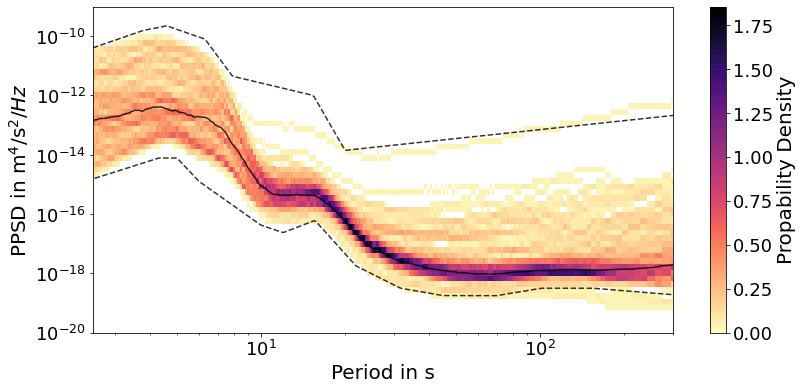

In [64]:
fig = __makeplot_PPSD(pp, output, config, mode="PSD", plot_noise_models=True)

In [65]:
fig.savefig(config['outdir_figures']+"PPSD_all_stations"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)